# Analytics - Linear Regression Challenge

Common end-to-end ML project schedule to take inspirations from

    (1) Look at the Big Picture
            Frame the Problem
            Select a Performance Measure
            Check the Assumptions
    (2) Get the Data
            Create the Workspace
            Download the Data
            Take a Quick Look at the Data Structure
            Create a Test Set
    (3) Discover and Visualize the Data to Gain Insights
            Visualizing Geographical Data
            Looking for Correlations
            Experimenting with Attribute Combinations
    (4) Prepare the Data for Machine Learning Algorithms
            Data Cleaning
            Handling Text and Categorical Attributes
            Custom Transformers
            Feature Scaling
            Transformation Pipelines
    (5) Select and Train a Model
            Training and Evaluating on the Training Set
            Better Evaluation Using Cross-Validation
    (6) Fine-Tune Your Model
            Grid Search
            Randomized Search
            Ensemble Methods (Random forest and Gradient Boosting)
            Analyze the Best Models and Their Errors
            Evaluate Your System on the Test Set


(TODO) My Index: 

    (1) Description of the challenge
    (2) Data description 
    (3) Data visualization 
    (4) Data preprocessing -> Pipeline
    (5) Scope definition
    (6) Models definition
    (7) Model-tuning and cross-validation for optimization!
    (8) Conclusions

## (1) Challenge description

### (TODO) Here we provide a little overview of what we are required to do with my own words (rephrase the problem)

Here attached a csv file containing a sample dataset consisting in (x, y) pairs on which you’ll have to perform a regression task. Here’s what you’ll need to do:

    1.	Open the file and read the data.
    2.	Clean the data if needed.
    3.	Plot the data.
    4.	Fit two different regression models to the data (e.g. curves belonging to two different families).
    5.	Choose a metric for the evaluation of the models and perform the evaluation using cross-validation.
    6.	Plot the predictions from the best model against the data.

We ask you to work in a Jupyter notebook specifying the versions of Python (version 3.x please) and all libraries you use: when you’re done send us the notebook and we’ll execute it and check the results. As an alternative, you can also work in a script: just make sure the results from cross-validation are printed to screen when we execute it via the terminal, and that the plots get saved as files in png format in the same directory containing the script (send us a compressed archive with the script and the plots you produced).


## (2) Dataset overview [TODO]

### (TODO) In this section we are going to load the data, conduct a preliminary analysis on the main characteristics of the data provided to get a sense on how we should proceed in our analysis (data to be cleaned? standardization vs. normalization? univariate vs. bivariate analysis?)

    (1) Complete description
    (2) See what we can add in order to perform a better analysis!

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("analytics_task_data.csv")

In [3]:
df.head()

,x,y
0,8.519119,48.073811
1,12.059918,302.657224
2,11.547357,247.531965
3,10.383055,127.686318
4,8.492261,55.086710


In [4]:
df.describe()

,x,y
count,488.000000,462.000000
mean,9.767819,133.752630
std,1.614540,91.797160
min,7.007803,10.443932
25%,8.380894,59.919619
50%,9.781597,104.201239
75%,11.122550,194.316855
max,12.498972,375.943890


In [5]:
# If there are missing values, we wish to see an overview for each column
if np.array(df.isnull().any()).any() == True: # TODO: This code might need some improvements!
    missing_data_sum = df.isnull().sum()
    print(missing_data_sum)

x    12
y    38
dtype: int64


In [6]:
# Wish to go a little more in-depth with these missing values 

# Percentage of missings over total
print(f"""Percentage of missings over total for each column:

        x: {missing_data_sum.x/len(df.x) * 100}% \t 
        y: {missing_data_sum.y/len(df.y) * 100}% 
""")

Percentage of missings over total for each column:

        x: 2.4% 	 
        y: 7.6% 



In [7]:
# Given low percentages of data missing compared to overall size, we might want to proceed to drop them. However, we make a consideration here:
# x -> drop (we might be to impute with sophisticated imputer such as KNN since a simpler one would probably get to a faulty road)
# y -> drop them, but store on an external file that would work as a test data. Why? Well, because we might want to see how the two models perform on data that they have never seen before and plot how the line fit with these values

## (1) Treat missings from dependent ("y")

# Retrieve indeces for null values
na_y_indeces = df.y[df.y.isnull()].index

# Store values of "x" (for which "y" is null) in a new dataframe with new keys
x_test = pd.DataFrame({
    "x": df.x.loc[na_y_indeces].to_numpy()
})

# Save the data in a new file -> analytics_task_data_test.csv
x_test.to_csv("analytics_task_data_test.csv")

# Drop these values from the original dataframe
df.dropna(axis=0,subset=["y"], inplace=True)

# Assert that all proceeded as planned
assert np.in1d(df.x,x_test.x).any() == False

## (3) Data visualization [TODO]

#### (TODO) Data visualization is a fundamental step in order to further explore the relationship between predictor(s) and target variable

    (1) Might need the course on Kaggle to do a good job here!
    (2) Univariate vs. Bivariate analysis:
            Boxplots
            Scatter plots
    (3) Remember to add a final evaluation of the curve on the test set!

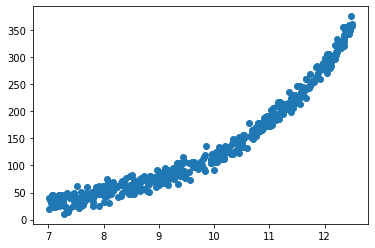

In [8]:
from matplotlib import pyplot as plt

# Scatter plot to see relationship
plt.scatter(df.x,df.y) 

# (1) seems like there is a strong relationship here, but for sure it is not linear!

# (2) what about univariate analysis? boxplots? 

## (4) Data preprocessing + (5) Data Modeling 

#### (TODO) Data preprocessing step will enable us to get our hands on the data and to correct them in order to avoid as much as possible pitfalls in modeling   

    (1) Drop vs. imputing
    (2) Standardization? Normalization? -> based on the data visualization analysis
    (3) Create a pipeline with point (4) Preprocessing + (5) Model definition x 2 + (6) Cross-validation + Hyper-parameter tuning -> get_score + (7) Metrics

Different approaches for data-preprocessing for x

In [9]:
## (2) [From point (2)] Treat missings from explanatory ("x") 

# 1st approach -> Drop them
df.dropna(axis=0,subset=["x"], inplace=True)

# 2nd approach -> Simple imputer 
#(TODO) -> Want to see whether such an approach improve performances, but I would already consider to drop the missing values for "x" anyway since they represent only the 2.7% of the overall sample. Moreover, the data provided already defines a clear trend (N.B.which might actually be present only in the sample data). 

# 3rd approach -> More complex imputer -> KNN? 
#(TODO)

Prepare variables for regression and define the train-validation set split

In [10]:
# Need to split train-validation sets before
from sklearn.model_selection import train_test_split

# Split between explanatory and predictor variable and reshaped to include another axis before splitting
x = df.x.values.reshape(-1,1)
y = df.y.values.reshape(-1,1)

# Train-validation split with default parameters
x_train,x_valid,y_train,y_valid = train_test_split(x,y)

I want to pass the whole execution to a pipeline so that it is easier to replicate, mantain and to read!

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# from sklearn.preprocessing import Normalizer # NOT YET!
# from sklearn.preprocessing import StandardScaler # NOT YET!

# (1) Define transformers 
# Polynomial-degree transformer with a degree of 2 (parameter to be optimized sooner or later!)
my_poly_transformer = PolynomialFeatures(degree=2)

# (2) Define the model
my_poly_model = LinearRegression()

# (3) Define the pipeline: bundle together data preprocessing and model definition
my_pipeline = make_pipeline(my_poly_transformer,my_poly_model)

# (4) Fit the pipeline
my_pipeline.fit(x_train,y_train)

# (5) Get predictions (N.B. this will procedure will preprocess also validation data thanks to the pipeline procedure!)
y_poly_preds = my_pipeline.predict(x_valid)

## (5) Model Definition

#### (TODO) Based on the analysis we have conducted so far, we want to pick the best model that represents the relationship between the explanatory (x) and the dependent variable (y)

(TODO) In this section we are going to defined two different regression models based on the analysis we conducted so far. Based on the visualizations, we already know that the relationship between the two variables is not linear, and for this reason we can exclude a linear regression model which would then underfit our data. We need to add more complexity to the models, and we do by introducing non-linearity in the model: Polynomial!

## (6) Model tuning and cross-validation for optimization

#### (TODO) Is the model we picked the best we could possibly pick? We might need to twist a little the parameters in order to get the best model and at the same time we wish to take care of underfitting vs. overfitting and bias-variance trade-off issues 

In [12]:
# No validation for linear model

## (7) Metrics evaluation

#### (TODO) MSE? RMSE? How should we evaluate the model performance? This might be included in cross-valudation and optimization of hyperparameters (such as the the polynomial line or regression!)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# RMSE
# rmse = np.sqrt(mean_squared_error(y_valid,y_pred))
rmse = np.sqrt(mean_squared_error(y_valid,y_poly_preds))
print(f"RMSE: {rmse}")

# R2 Score: how much variance is explained by the model?
# r2 = r2_score(y_valid,y_pred)
r2 = r2_score(y_valid,y_poly_preds)
print(f"R2 Score: {r2}")

RMSE: 9.286662944069226
R2 Score: 0.9876640431349165


# (Bonus) Results

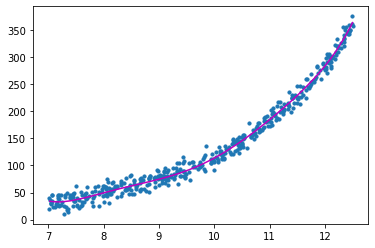

In [14]:
import operator

plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_valid,y_poly_preds), key=sort_axis)
x_plot, y_plot = zip(*sorted_zip)
plt.plot(x_plot, y_plot, color='m')

## (8) Conclusions

#### (TODO) What can we conclude from this analysis? Write a little description summarizing the findings and how we approach a final solution

# (NO NEED TO LOOK BELOW HERE!) The rest? Is trial-and-error. Wish to follow the schedule delined in order to exploit a full end-to-end ML analysis!

Here below we want to take a step ahead: we want to define a function to perform parameter optimization for the polynomial-degree hyperparameter

In [ ]:
def get_score(poly_degree=2):
    """
        Function to evaluate the best hyperparameter for polynomial degree equation to fit the line with pipelines
    """
    # (1) Define column transformers
    # (2) Define model
    # (3) Construct the pipeline and fit the model (with cross-validation)
    # (4) Return the evaluation metrics
    
    pass

# Handling missing values

In [ ]:
# Train-validation set split
X_train,X_valid,y_train,y_valid = train_test_split(df,df.y,random_state=1)

In [ ]:
# Let's try with missing values
# Retrieve the columns that have missings (all of them)
cols_with_missings = [col for col in df.columns if df[col].isnull().any()]

# Explicative situation for each column regarding missing values
missing_values_count_by_cols = (df.isnull().sum())
print(missing_values_count_by_cols[missing_values_count_by_cols > 0])

In [ ]:
## Just drop values from a SUBSET!
# df.dropna(axis=0,subset=['x'],inplace=True) # drops all the observations for which "x" is null
# df.dropna(axis=0,subset=['y'],inplace=True) # drops all the observations for which "y" is null

In [ ]:
# ## IMPUTING VALUES
# from sklearn.impute import SimpleImputer

# # Imputed values
# my_imputer = SimpleImputer()
# imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
# imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# # Restore column names
# imputed_X_train.columns = X_train.columns
# imputed_X_valid.columns = X_valid.columns